In [42]:
import time
start_time = time.time()

"""
Label propagation community detection algorithms.
"""
from collections import Counter

import networkx as nx
from networkx.utils import groups
from networkx.utils import not_implemented_for
from networkx.utils import py_random_state

__all__ = ["label_propagation_communities", "asyn_lpa_communities"]



def asyn_lpa_communities(G, weight=None, seed=None):


    labels = {n: i for i, n in enumerate(G)}
    cont = True
    while cont:
        cont = False
        nodes = list(G)
        seed.shuffle(nodes)
        # Calculate the label for each node
        for node in nodes:
            if len(G[node]) < 1:
                continue

            # Get label frequencies. Depending on the order they are processed
            # in some nodes with be in t and others in t-1, making the
            # algorithm asynchronous.
            label_freq = Counter()
            for v in G[node]:
                label_freq.update(
                    {labels[v]: G.edges[node, v][weight] if weight else 1}
                )
            # Choose the label with the highest frecuency. If more than 1 label
            # has the highest frecuency choose one randomly.
            max_freq = max(label_freq.values())
            best_labels = [
                label for label, freq in label_freq.items() if freq == max_freq
            ]

            # Continue until all nodes have a majority label
            if labels[node] not in best_labels:
                labels[node] = seed.choice(best_labels)
                cont = True

    yield from groups(labels).values()



def label_propagation_communities(G):
    """Generates community sets determined by label propagation

    Finds communities in `G` using a semi-synchronous label propagation
    method[1]_. 

    Parameters
    ----------
    G : graph
        An undirected NetworkX graph.

    Yields
    ------
    communities : generator
        Yields sets of the nodes in each community.

    """
    coloring = _color_network(G)
    # Create a unique label for each node in the graph
    labeling = {v: k for k, v in enumerate(G)}
    while not _labeling_complete(labeling, G):
        # Update the labels of every node with the same color.
        for color, nodes in coloring.items():
            for n in nodes:
                _update_label(n, labeling, G)

    for label in set(labeling.values()):
        yield {x for x in labeling if labeling[x] == label}



def _color_network(G):
    """Colors the network so that neighboring nodes all have distinct colors.

    Returns a dict keyed by color to a set of nodes with that color.
    """
    coloring = dict()  # color => set(node)
    colors = nx.coloring.greedy_color(G)
    for node, color in colors.items():
        if color in coloring:
            coloring[color].add(node)
        else:
            coloring[color] = {node}
    return coloring


def _labeling_complete(labeling, G):
    """Determines whether or not LPA is done.

    Label propagation is complete when all nodes have a label that is
    in the set of highest frequency labels amongst its neighbors.

    Nodes with no neighbors are considered complete.
    """
    return all(
        labeling[v] in _most_frequent_labels(v, labeling, G) for v in G if len(G[v]) > 0
    )


def _most_frequent_labels(node, labeling, G):
    """Returns a set of all labels with maximum frequency in `labeling`.

    Input `labeling` should be a dict keyed by node to labels.
    """
    if not G[node]:
        # Nodes with no neighbors are themselves a community and are labeled
        # accordingly, hence the immediate if statement.
        return {labeling[node]}

    # Compute the frequencies of all neighbours of node
    freqs = Counter(labeling[q] for q in G[node])
    max_freq = max(freqs.values())
    return {label for label, freq in freqs.items() if freq == max_freq}


def _update_label(node, labeling, G):
    """Updates the label of a node using the Prec-Max tie breaking algorithm

    The algorithm is explained in: 'Community Detection via Semi-Synchronous
    Label Propagation Algorithms' Cordasco and Gargano, 2011
    """
    high_labels = _most_frequent_labels(node, labeling, G)
    if len(high_labels) == 1:
        labeling[node] = high_labels.pop()
    elif len(high_labels) > 1:
        # Prec-Max
        if labeling[node] not in high_labels:
            labeling[node] = max(high_labels)


In [43]:
import networkx as nx
g = nx.read_edgelist('./dataset/facebook_combined.txt',create_using = nx.Graph(), nodetype = int)


In [44]:
ccs = [c for c in nx.community.label_propagation_communities(g)]
comms = len(ccs)

print("Communities:", comms)
print("Q:", nx.community.quality.modularity(g, ccs))

node_colors_map = {}
for i, lg in enumerate(ccs):
    for node in lg:
        node_colors_map[node] = i/comms
node_colors = [node_colors_map[n] for n in g.nodes]


sp = nx.spring_layout(g)



Communities: 44
Q: 0.7368407345343148


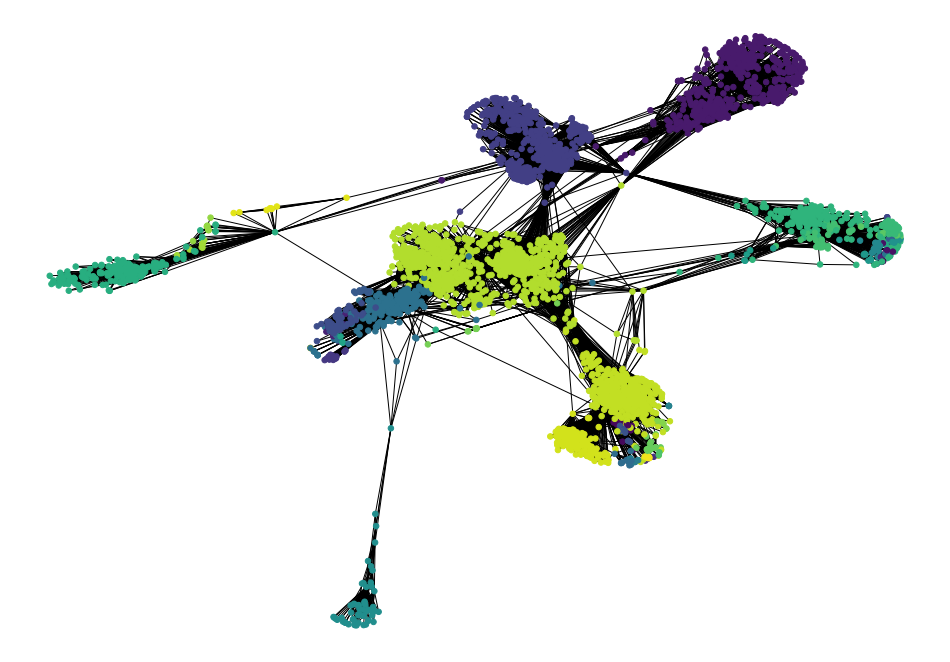

In [45]:
import matplotlib.pyplot as plt
plt.figure(figsize=(13, 9))
nx.draw(g, pos=sp, node_color=node_colors,with_labels =False,alpha =1.0,node_size=30)
plt.show()

In [46]:
print("--- %s seconds ---" % (time.time() - start_time))

--- 144.30484127998352 seconds ---
